In [42]:
import json
import numpy as np
import pandas as pd
import glob, os
import re
import gzip
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [16]:
# Função para ler e extrair o conteúdo do arquivo GML comprimido
def extract_gml(file_path):
    with gzip.open(file_path, 'rt') as f:
        content = f.read()
    return content

# Função para processar o conteúdo GML e extrair as informações
def process_gml(gml_content):
    # Extrair os nós (id, grau)
    nodes = re.findall(r'node\s*\[\s*id (\d+)\s*label \d+\s*graphics\s*\[\s*x (-?\d+\.\d+)\s*y (-?\d+\.\d+)\s*z (-?\d+\.\d+)\s*\]\s*degree (\d+)\s*\]', gml_content)

    node_info = []
    for node in nodes:
        node_id = int(node[0])
        x, y, z = map(float, node[1:4])
        degree = int(node[4])
        node_info.append({
            "id": node_id,
            "coordinates": (x, y, z),
            "degree": degree
        })

    # Extrair as arestas (pares conectados) e as distâncias
    edges = re.findall(r'edge\s*\[\s*source (\d+)\s*target (\d+)\s*distance (-?\d+\.\d+)\s*\]', gml_content)

    edge_info = []
    for edge in edges:
        source, target, distance = map(float, edge)
        edge_info.append({
            "source": int(source),
            "target": int(target),
            "distance": distance
        })

    return node_info, edge_info

def convert_to_lists(node_data, edge_data):
    
    degree = [node_data[i]['degree'] for i in range(len(node_data))]
    connected_pairs = [(edge_data[i]["source"],edge_data[i]["target"]) for i in range(len(edge_data))]
    distances = [edge_data[i]['distance'] for i in range(len(edge_data))]

    return connected_pairs, distances, degree

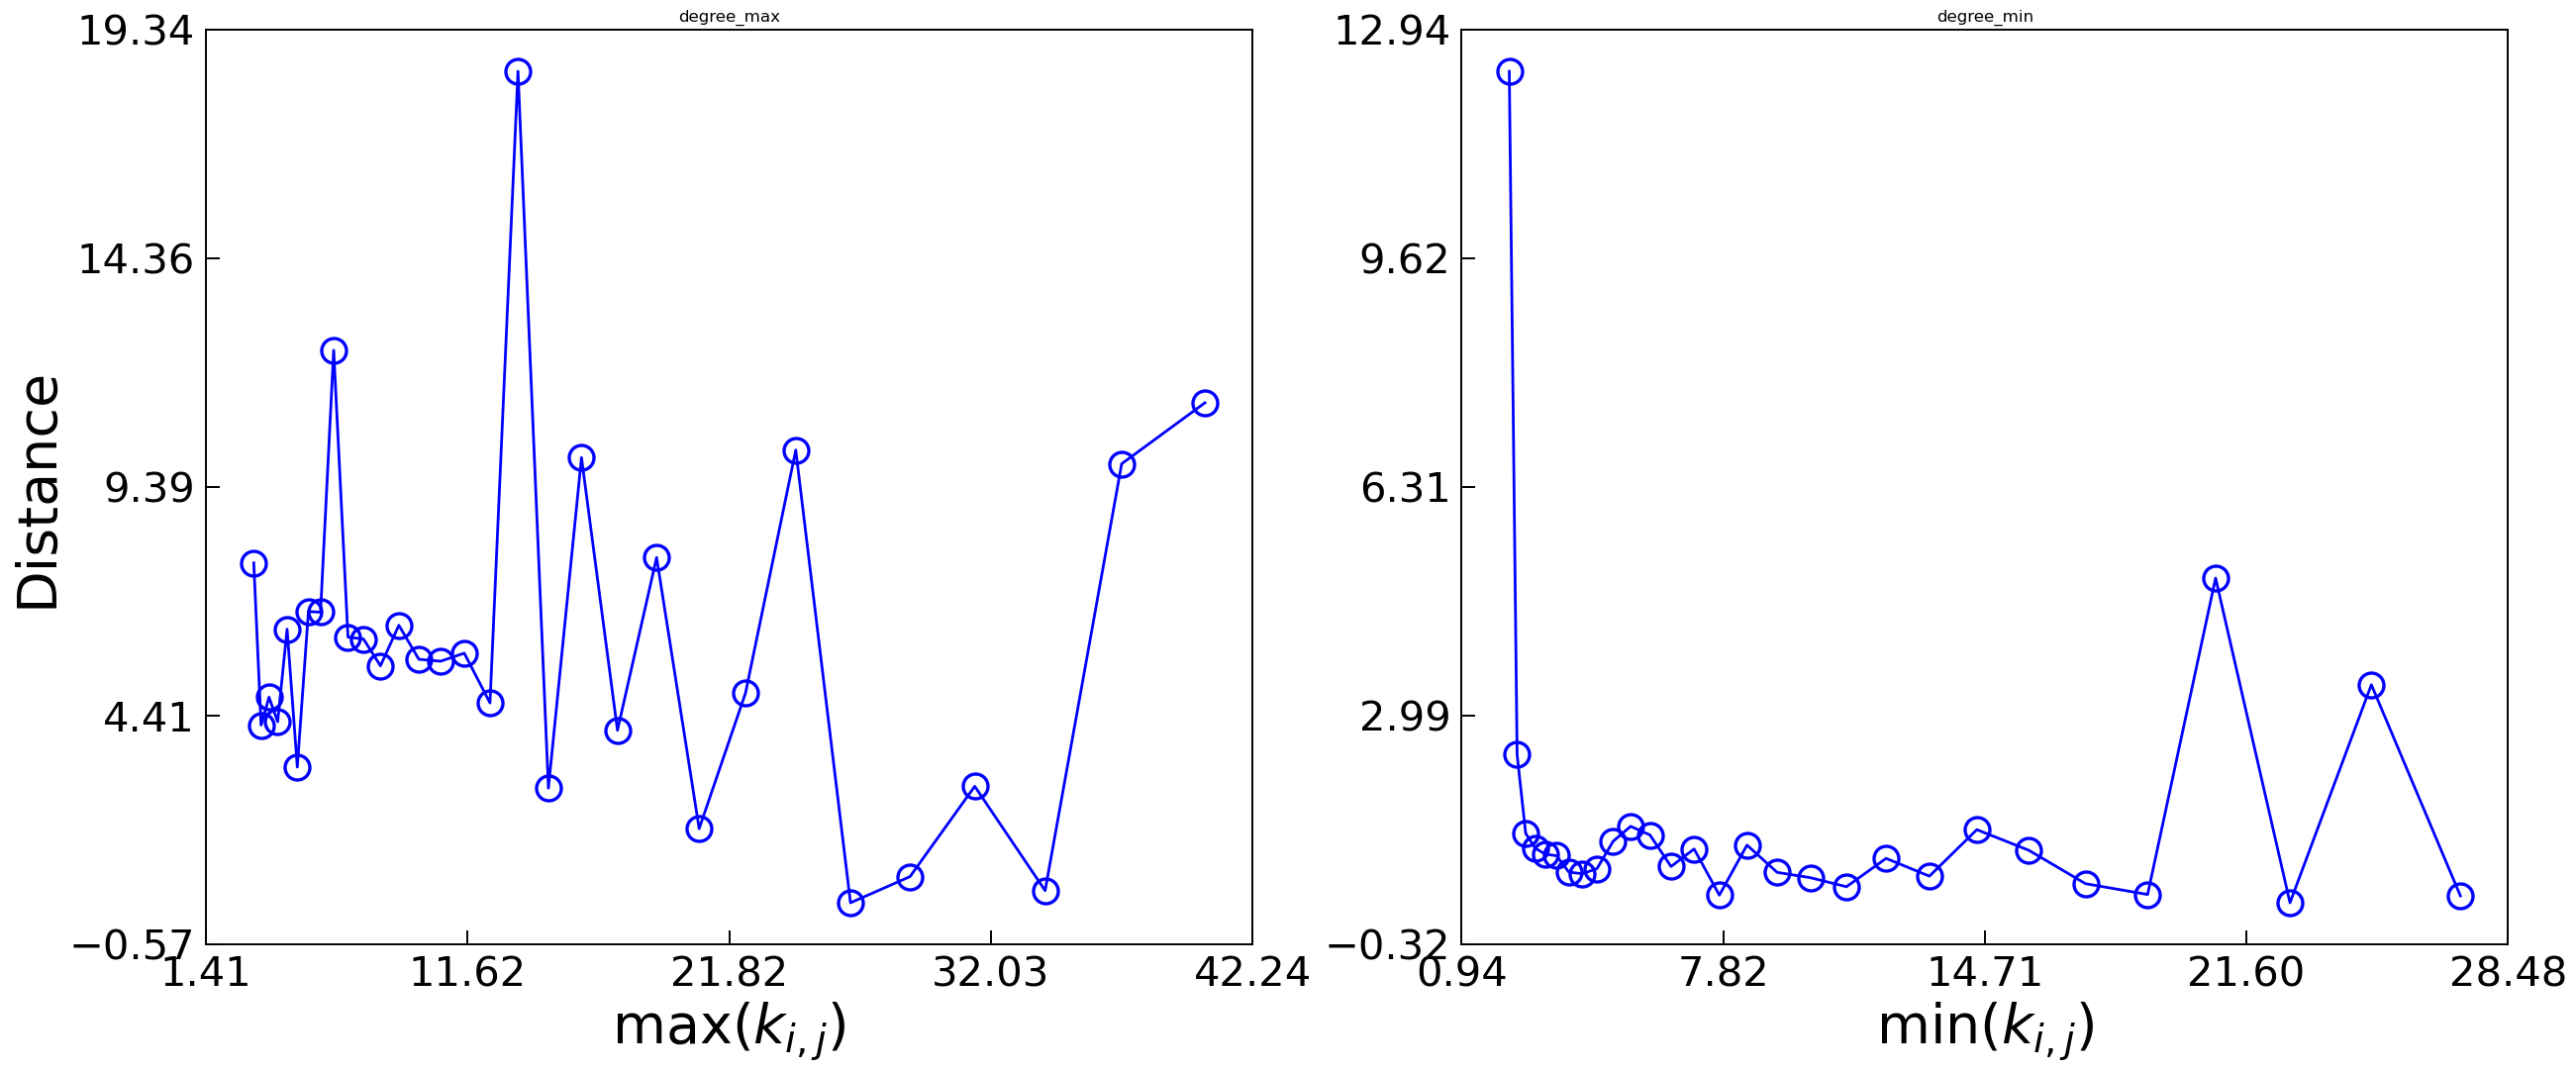

In [ ]:
from scipy.stats import spearmanr
from matplotlib import ticker
# Função para calcular as médias aritméticas e ponderadas por faixa de k
def calculate_means(degrees, distances, intervals):
    # Armazenar os resultados das médias
    arithmetic_means = []
    weighted_means = []
    for i in range(len(intervals) - 1):
        # Encontrar os índices dos valores de k dentro de cada intervalo
        indices = np.where((degrees >= intervals[i]) & (degrees < intervals[i+1]))[0]
        
        if len(indices) > 0:
            # Média aritmética
            arithmetic_mean = np.mean(distances[indices])
            arithmetic_means.append(arithmetic_mean)
            
            # Média ponderada (usando o grau máximo como peso)
            weighted_mean = np.average(distances[indices], weights=degrees[indices])
            weighted_means.append(weighted_mean)
    
    return arithmetic_means, weighted_means, intervals

path = "../../data/N_100000/m0_2/dim_1/alpha_a_2.00_alpha_g_1.00/gml/gml_298712619.gml.gz"
gml_content = extract_gml(path)
node_data, edge_data = process_gml(gml_content)

conected_pairs, distances, degrees = convert_to_lists(node_data, edge_data)
distances = np.array(distances)
degree_MAX = np.array([max(degrees[conected_pairs[i][0]],degrees[conected_pairs[i][1]]) for i in range(len(distances))])
degree_MIN = np.array([min(degrees[conected_pairs[i][0]],degrees[conected_pairs[i][1]]) for i in range(len(distances))])
dict_all = {"degree_max":degree_MAX, "degree_min":degree_MIN}
labels_x = [r'$\max(k_{{i,j}})$',r'$\min(k_{{i,j}})$']

thickness_axes = 1.4
ticks_label_size = 30
fontsize_labels = 40
ms = 18
mew = 2.4

fig, ax = plt.subplots(1, 2, figsize=(30, 12))

for idx, keys in enumerate(dict_all):
    degree = dict_all[keys]
    # Definir intervalos de k (grau máximo) para realizar a média por faixa
    k_intervals = np.logspace(np.log10(min(degree)), np.log10(max(degree)), num=40)

    # Calcular as médias aritméticas e ponderadas
    arithmetic_means, weighted_means, intervals = calculate_means(degree, distances, k_intervals)

    # Ajustar o número de intervalos para corresponder ao número de médias calculadas
    valid_intervals = intervals[1:len(arithmetic_means) + 1]  # Intervalos válidos para os quais temos médias

    # Plotar as médias aritméticas e ponderadas com intervalos válidos
    ax[idx].plot(valid_intervals, arithmetic_means, 'o-', label='Média Aritmética',  ms=ms, lw=2.0,
                 mec='blue', mfc='none', mew=mew, color='blue')
    #ax[idx].plot(valid_intervals, weighted_means, 'o-', label='Média Ponderada',  ms=ms, mec='blue', mfc='none', mew=mew)
    ax[idx].set_title(f"{keys}")
    ax[idx].set_xlabel(labels_x[idx], fontsize=fontsize_labels)
    
    
    # Ticks x-label
    ax[idx].xaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax[idx].xaxis.set_minor_locator(ticker.LinearLocator(numticks=5))
    
    # Ticks y-label
    ax[idx].yaxis.set_major_locator(ticker.LinearLocator(numticks=5))
    ax[idx].yaxis.set_minor_locator(ticker.LinearLocator(numticks=5))

    ax[idx].tick_params(axis='both', which='major', direction='in', length=10, width=thickness_axes, labelsize=ticks_label_size, pad=8.0)
    ax[idx].tick_params(axis='both', which='minor', direction='in', length=7, width=thickness_axes)
    for spine in ax[idx].spines.values():
        spine.set_linewidth(thickness_axes)

ax[0].set_ylabel('Distance', fontsize=fontsize_labels)
plt.show()